In [1]:
# Improt the necessary libraries
import itertools
import xarray as xr
import rasterio
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
WTE_FOLDER = "/mnt/drive/AI4EBV/INPUTS/WTE/"

# Wte table
WTE_TABLE = WTE_FOLDER + "Tables/Realm_WE_attribute_Table_DraftSort_colors.csv"

In [3]:
wte_table = pd.read_csv(WTE_TABLE, sep=',')
wte_table

,Unnamed: 0,LF_Name,LC_Name,Temp_Moist,RealmWE_ID,WE_ID,Realm_ID,RealmClass,LF_Class,MoistClass,...,WEcosystm,RWEcosystm,LandC_Type,Code,CR_HEX,LC_HEX,LF_HEX,TempMoistClass,WTE_code,WTE_HEX
0,1,Hills,Cropland,Sub Tropical Moist,5267,267,5000,5,2,3,...,Sub Tropical Moist Cropland on Hills,Nearctic Sub Tropical Moist Cropland on Hills,Converted,4321,#FCC24E66,#B5D99EFF,#7DC756B2,12,1212,#bac860
1,2,Hills,Forest,Sub Tropical Dry,5290,290,5000,5,2,2,...,Sub Tropical Dry Forest on Hills,Nearctic Sub Tropical Dry Forest on Hills,Natural,4223,#FCE30066,#267300FF,#7DC756B2,11,3211,#a0c324
2,3,Hills,Settlement,Tropical Moist,3407,407,3000,3,2,3,...,Tropical Moist Settlement on Hills,Australasia Tropical Moist Settlement on Hills,Converted,5325,#66240566,#8A4343FF,#7DC756B2,15,5215,#766e32
3,4,Hills,Cropland,Sub Tropical Desert,5349,349,5000,5,2,1,...,Sub Tropical Desert Cropland on Hills,Nearctic Sub Tropical Desert Cropland on Hills,Converted,4121,#FFF7BA66,#B5D99EFF,#7DC756B2,10,1210,#bbdd8b
4,5,Hills,Grassland,Sub Tropical Dry,5279,279,5000,5,2,2,...,Sub Tropical Dry Grassland on Hills,Nearctic Sub Tropical Dry Grassland on Hills,Natural,4224,#FCE30066,#789E60FF,#7DC756B2,11,4211,#afcb35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,1777,Tablelands,Snow and Ice,Polar Moist,5011,11,5000,5,3,3,...,Polar Moist Snow and Ice on Tablelands,Nearctic Polar Moist Snow and Ice on Tablelands,Natural,6338,#BFBFBF66,#B4B6CCFF,#8B6CE0B2,18,8318,#a79bcf
1777,1778,Tablelands,Grassland,Polar Dry,6038,38,6000,6,3,2,...,Polar Dry Grassland on Tablelands,Neotropic Polar Dry Grassland on Tablelands,Natural,6234,#DBDBDB66,#789E60FF,#8B6CE0B2,17,4317,#a8a1c7
1778,1779,Tablelands,Grassland,Polar Moist,1026,26,1000,1,3,3,...,Polar Moist Grassland on Tablelands,Afrotropic Polar Moist Grassland on Tablelands,Natural,6334,#BFBFBF66,#789E60FF,#8B6CE0B2,18,4318,#9c96bc
1779,1780,Tablelands,Settlement,Boreal Moist,5094,94,5000,5,3,3,...,Boreal Moist Settlement on Tablelands,Nearctic Boreal Moist Settlement on Tablelands,Converted,1335,#2C8EBF66,#8A4343FF,#8B6CE0B2,3,5303,#6572b7


## WTE Ecosystem map from single WTE component

Read the files generated during the validation of the components

In [4]:
TEMPERATURE_LAYER = "./wte_temp_UTM_ST.nc"
MOISTURE_LAYER    = "./wte_moist_UTM_ST.nc"
LANDFORM_LAYER    = "./wte_lf_UTM_ST.nc"
LANDCOVER_LAYER   = "./wte_lc_UTM_ST.nc"

In [5]:
temp = xr.open_dataset(TEMPERATURE_LAYER).to_array()[0]
moist = xr.open_dataset(MOISTURE_LAYER).to_array()[1]
landform = xr.open_dataset(LANDFORM_LAYER).to_array()[1]
landcover = xr.open_dataset(LANDCOVER_LAYER).to_array()[1]
landcover_array  = np.copy(landcover.values)
landform_array  = np.copy(landform.values)
moisture_array  = np.copy(moist.values)
temperature_array  = np.copy(temp.values)

In [6]:
# Utility function to convert HEX RGB colors to R,G,B in uint8 (0-255)
def hex_to_rgb(hex_color_string):
    hex_color_string = hex_color_string.lstrip('#')
    return tuple(int(hex_color_string[i:i+2], 16) for i in (0, 2, 4))

In [7]:
ecosystem_R  = np.ones(landcover_array.shape)*255
ecosystem_G  = np.ones(landcover_array.shape)*255
ecosystem_B  = np.ones(landcover_array.shape)*255

ecosystem_map_wte  = np.zeros(landcover_array.shape)

number_of_valid_pixels = np.count_nonzero(landcover_array)

wte_labels = {}

tot_class_numb = 0

for lc in range(1,9): # landcover
#     print("Landcover: ",lc)
    lc_mask = landcover_array==lc
    color0 = wte_table.loc[wte_table['LC_Class']==lc]
    lc_class_value = lc
    for lf in range(1,6):
#         print("Landform: ",lf)
        lf_mask = landform_array==lf
        color1 = color0.loc[wte_table['LF_Class']==lf]
        lf_class_value = lf*10
        for mois in range(1,4):
#             print("Moisture: ",mois)
            moist_mask = moisture_array==mois
            color2 = color1.loc[wte_table['MoistClass']==mois]
            moist_class_value = mois*100
            for t in range(0,6):
#                 print("Temperature: ",t)
                temperature_mask = temperature_array==t
                if t==0:
                    color3 = color2.loc[wte_table['TempClass']==6]
                    temp_class_value = 6*1000
                else:
                    color3 = color2.loc[wte_table['TempClass']==t]
                    temp_class_value = t*1000
                try:
                    color3['WTE_HEX'].values[0]
                    rgb_color = hex_to_rgb(color3['WTE_HEX'].values[0])
                    ecosystem_label = color3['WEcosystm'].values[0]
                    ecosystem_mask = lc_mask*lf_mask*moist_mask*temperature_mask
                    if (np.sum(ecosystem_mask)>0):
                        tot_class_numb +=1
#                         if ((np.sum(ecosystem_mask) / number_of_valid_pixels)>0.01): # This additional condition is used if we don't want to consider classes covering less than 1% of the area
                        ecosystem_R[ecosystem_mask] = rgb_color[0]
                        ecosystem_G[ecosystem_mask] = rgb_color[1]
                        ecosystem_B[ecosystem_mask] = rgb_color[2]
                        ecosystem_class = temp_class_value + moist_class_value + lf_class_value + lc_class_value
                        ecosystem_map_wte[ecosystem_mask] = ecosystem_class
                        wte_labels[str(int(ecosystem_class))] = ecosystem_label
                except:
                    continue

ecosystem_map_wte = ecosystem_map_wte.astype(int)
wte_ecosystem = np.stack([ecosystem_R,ecosystem_G,ecosystem_B],axis=2)

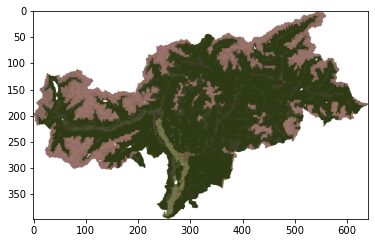

In [8]:
plt.imshow(wte_ecosystem.astype(np.uint8),cmap='brg')

## WTE Ecosystem map from local layers
Temperature: EURAC, Moisture: Chelsa, Landform: EURAC, Land Cover: LISS (EURAC) ECOSYSTEM MAP

In [9]:
TEMPERATURE_LAYER = "./eurac_to_wte_temp_UTM_ST.nc"
MOISTURE_LAYER    = "./chelsa_to_wte_moist_UTM_ST.nc"
LANDFORM_LAYER    = "./lidar_to_wte_lf_UTM_ST.nc"
LANDCOVER_LAYER   = "./liss_lc_UTM_ST.nc"

In [10]:
temp = xr.open_dataarray(TEMPERATURE_LAYER)
moist = xr.open_dataarray(MOISTURE_LAYER)
landform = xr.open_dataarray(LANDFORM_LAYER)
landcover = xr.open_dataarray(LANDCOVER_LAYER)
landcover_array  = np.copy(landcover.values)
landform_array  = np.copy(landform.values)
moisture_array  = np.copy(moist.values)
temperature_array  = np.copy(temp.values)

In [11]:
ecosystem_R  = np.ones(landcover_array.shape)*255
ecosystem_G  = np.ones(landcover_array.shape)*255
ecosystem_B  = np.ones(landcover_array.shape)*255

ecosystem_map_eurac  = np.zeros(landcover_array.shape)

number_of_valid_pixels = np.count_nonzero(landcover_array)

eurac_labels = {}

tot_class_numb = 0

for lc in range(1,9): # landcover
    lc_mask = landcover_array==lc
    color0 = wte_table.loc[wte_table['LC_Class']==lc]
    lc_class_value = lc
    for lf in range(1,6):
        lf_mask = landform_array==lf
        color1 = color0.loc[wte_table['LF_Class']==lf]
        lf_class_value = lf*10
        for mois in range(1,4):
            moist_mask = moisture_array==mois
            color2 = color1.loc[wte_table['MoistClass']==mois]
            moist_class_value = mois*100
            for t in range(0,6):
                temperature_mask = temperature_array==t
                if t==0:
                    color3 = color2.loc[wte_table['TempClass']==6]
                    temp_class_value = 6*1000
                else:
                    color3 = color2.loc[wte_table['TempClass']==t]
                    temp_class_value = t*1000
                try:
                    color3['WTE_HEX'].values[0]
                    rgb_color = hex_to_rgb(color3['WTE_HEX'].values[0])
                    ecosystem_label = color3['WEcosystm'].values[0]
                    ecosystem_mask = lc_mask*lf_mask*moist_mask*temperature_mask
                    if (np.sum(ecosystem_mask)>0):
                        tot_class_numb +=1
#                         if ((np.sum(ecosystem_mask) / number_of_valid_pixels)>0.01):
                        ecosystem_R[ecosystem_mask] = rgb_color[0]
                        ecosystem_G[ecosystem_mask] = rgb_color[1]
                        ecosystem_B[ecosystem_mask] = rgb_color[2]
                        ecosystem_class = temp_class_value + moist_class_value + lf_class_value + lc_class_value
                        ecosystem_map_eurac[ecosystem_mask] = ecosystem_class
                        eurac_labels[str(int(ecosystem_class))] = ecosystem_label
                except:
                    continue
                    
ecosystem_map_eurac = ecosystem_map_eurac.astype(int)
eurac_ecosystem = np.stack([ecosystem_R,ecosystem_G,ecosystem_B],axis=2)

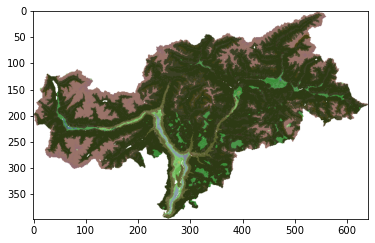

In [12]:
plt.imshow(eurac_ecosystem.astype(np.uint8),cmap='brg')

Compute the union of classes present in the WTE layer and the newly generated with global layers:

In [13]:
wte_eurac_classes = np.unique(np.concatenate([np.unique(ecosystem_map_wte),np.unique(ecosystem_map_eurac)])).astype(int)

Create a list with the corresponding class labels

In [14]:
wte_eurac_labels = []
for c in wte_eurac_classes:
    if c==0:
        wte_eurac_labels.append("NoClass")
        continue
    try:
        wte_eurac_labels.append(eurac_labels[str(c)])
    except:
        wte_eurac_labels.append(wte_labels[str(c)])

In [15]:
def plot_confusion_matrix(ax, cm, labels, normalize=True, cmap='Blues',true="WTE",predicted="predicted"):
    """Plot the confusion matrix ``cm``.
    Parameters
    ----------
    cm : :py:class:`numpy.ndarray`
        The confusion matrix.
    labels : `list` [`str`]
        Names of the classes.
    normalize : `bool`, optional
        Whether to normalize the confusion matrix. The default is `True`.
    figsize : `tuple` [`int`], optional
        The figure size in centimeters. The default is `(10, 10)`.
    cmap : `str`, optional
        A matplotlib colormap. The default is `'Blues'`.
    Returns
    -------
    fig : :py:class:`matplotlib.figure.Figure`
        An instance of :py:class:`matplotlib.figure.Figure`.
    ax : :py:class:`matplotlib.axes._subplots.AxesSubplot`
        An instance of :py:class:`matplotlib.axes._subplots.AxesSubplot`.
    """
    # number of classes
    nclasses = len(labels)

    # string format to plot values of confusion matrix
    fmt = '.0f'

    # minimum and maximum values of the colorbar
    vmin, vmax = 0, cm.max()

    # check whether to normalize the confusion matrix
    if normalize:
        # normalize
        norm = cm.sum(axis=1, keepdims=True)

        # check for division by zero
        norm[norm == 0] = 1
        cm = cm / norm

        # change string format to floating point
        fmt = '.2f'
        vmin, vmax = 0, 1

    # get colormap
    cmap = colormap.get_cmap(cmap, 256)

    # plot confusion matrix
    im = ax.imshow(cm, cmap=cmap, vmin=vmin, vmax=vmax)

    # threshold determining the color of the values
    thresh = (cm.max() + cm.min()) / 2

    # brightest/darkest color of current colormap
    cmap_min, cmap_max = cmap(0), cmap(256)

    # plot values of confusion matrix
    for i, j in itertools.product(range(nclasses), range(nclasses)):
        ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color=cmap_max if cm[i, j] < thresh else cmap_min)

    # axes properties and labels
    ax.set(xticks=np.arange(nclasses),yticks=np.arange(nclasses),xticklabels=labels,yticklabels=labels,ylabel=true,xlabel=predicted)

    # rotate x-tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

    return


Plot the confusion matrix

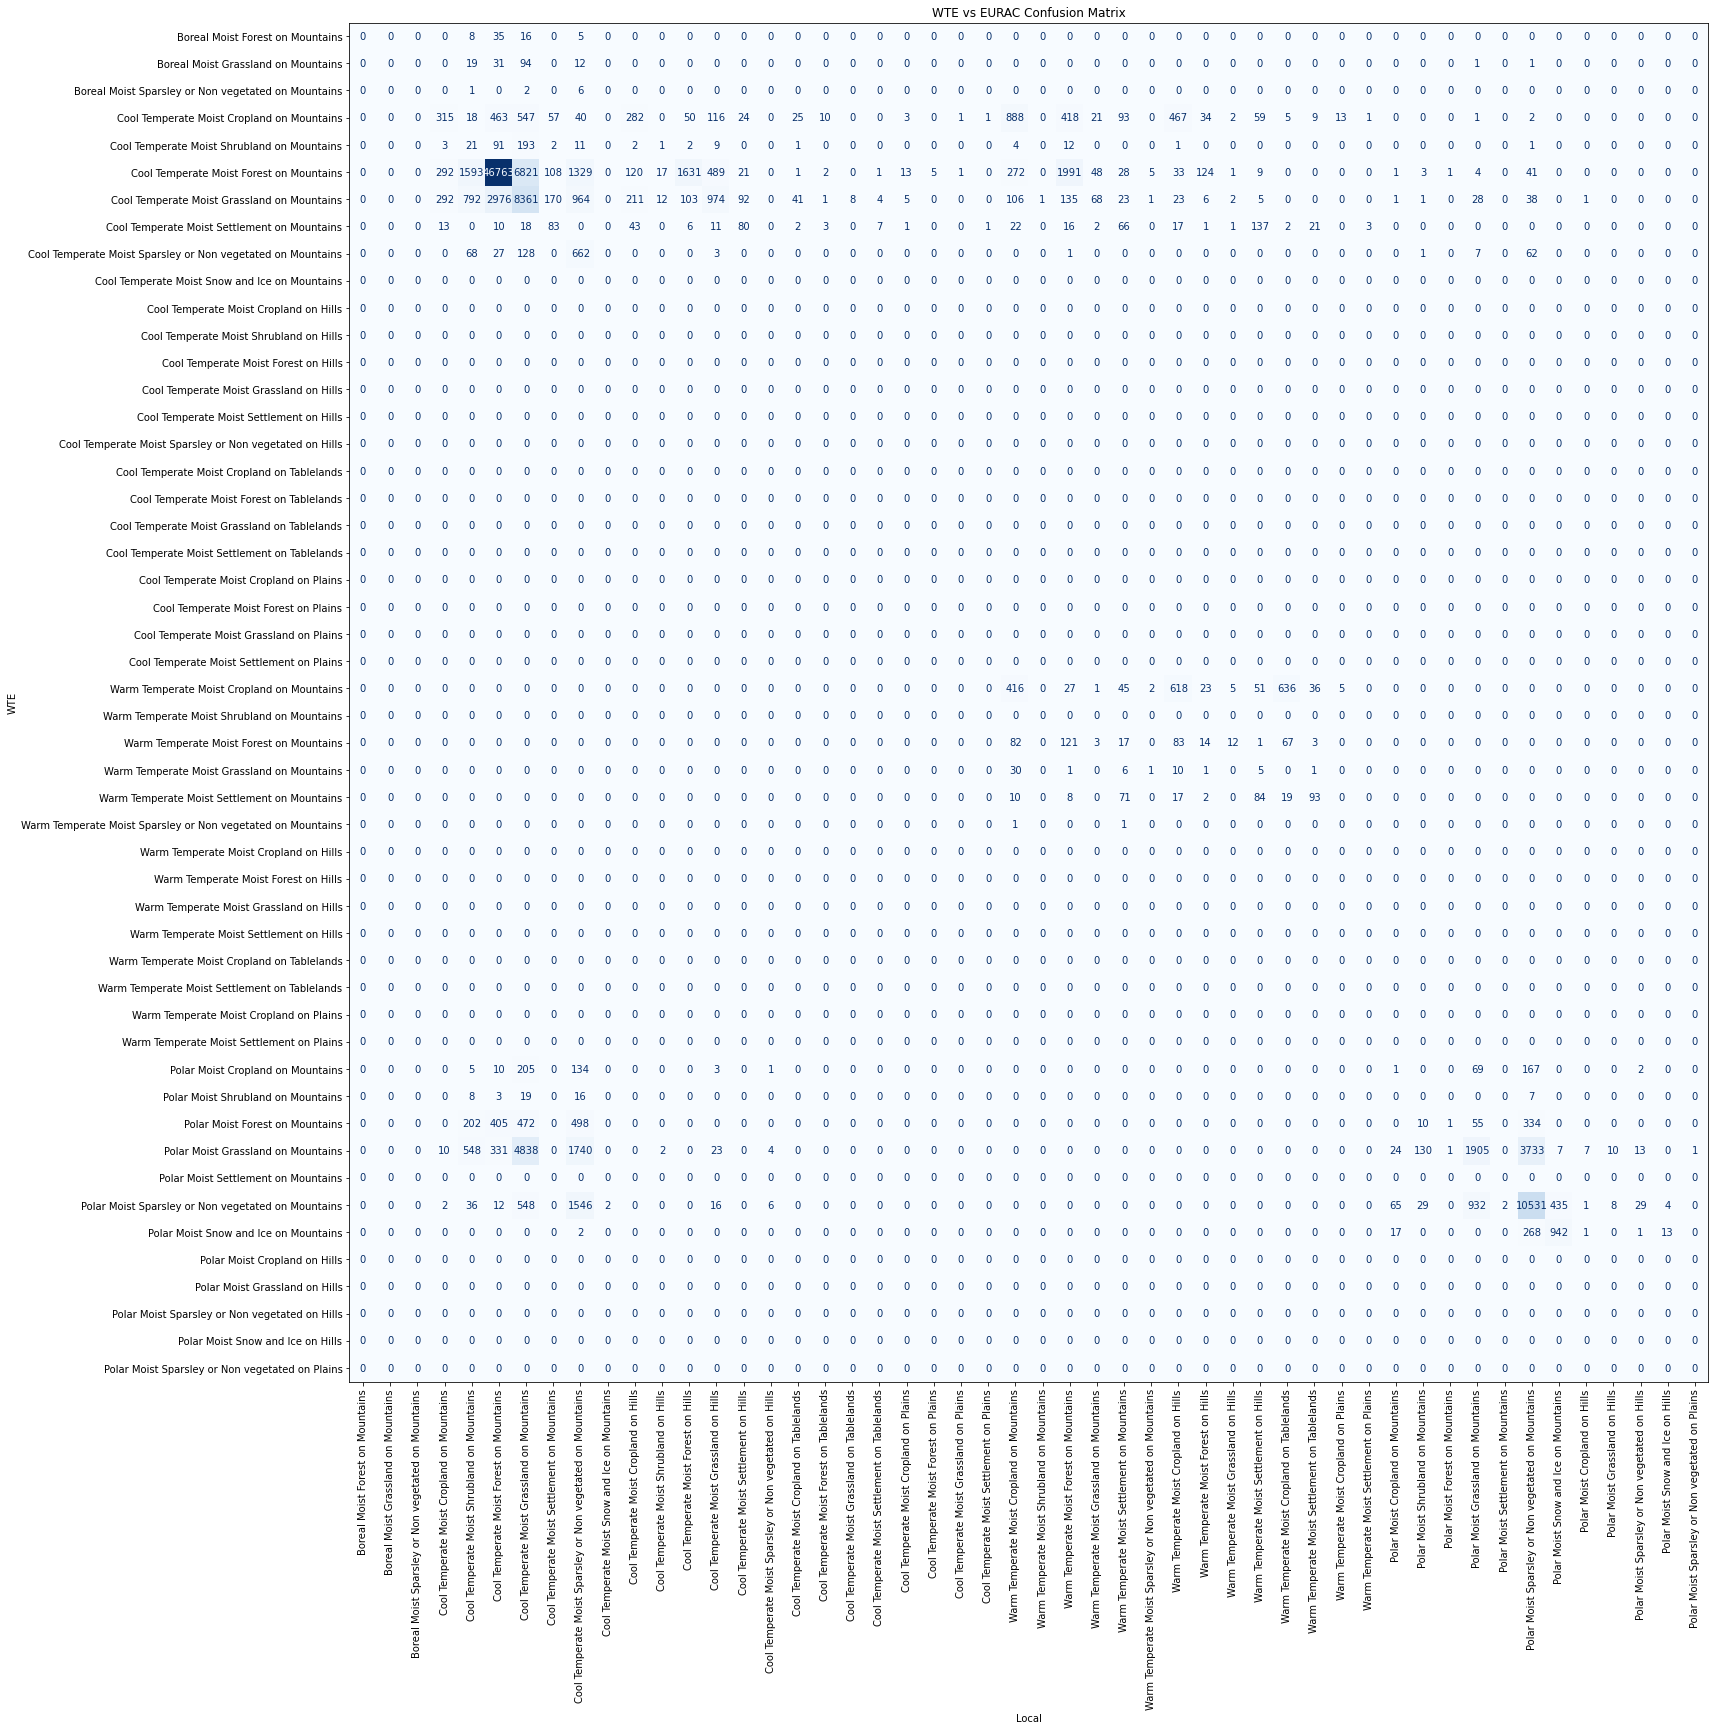

In [16]:
cm_wte_eurac = confusion_matrix(ecosystem_map_wte.flatten(), ecosystem_map_eurac.flatten(), labels=list(wte_eurac_classes))
cm_wte_eurac = cm_wte_eurac[1:,1:]
fig, ax = plt.subplots(1,1,figsize=(25,25))
ax.set_title("WTE vs EURAC Confusion Matrix")
plot_confusion_matrix(ax,cm_wte_eurac,wte_eurac_labels[1:],true="WTE",predicted="Local",normalize=None)

Plot the normalized confusion matrix

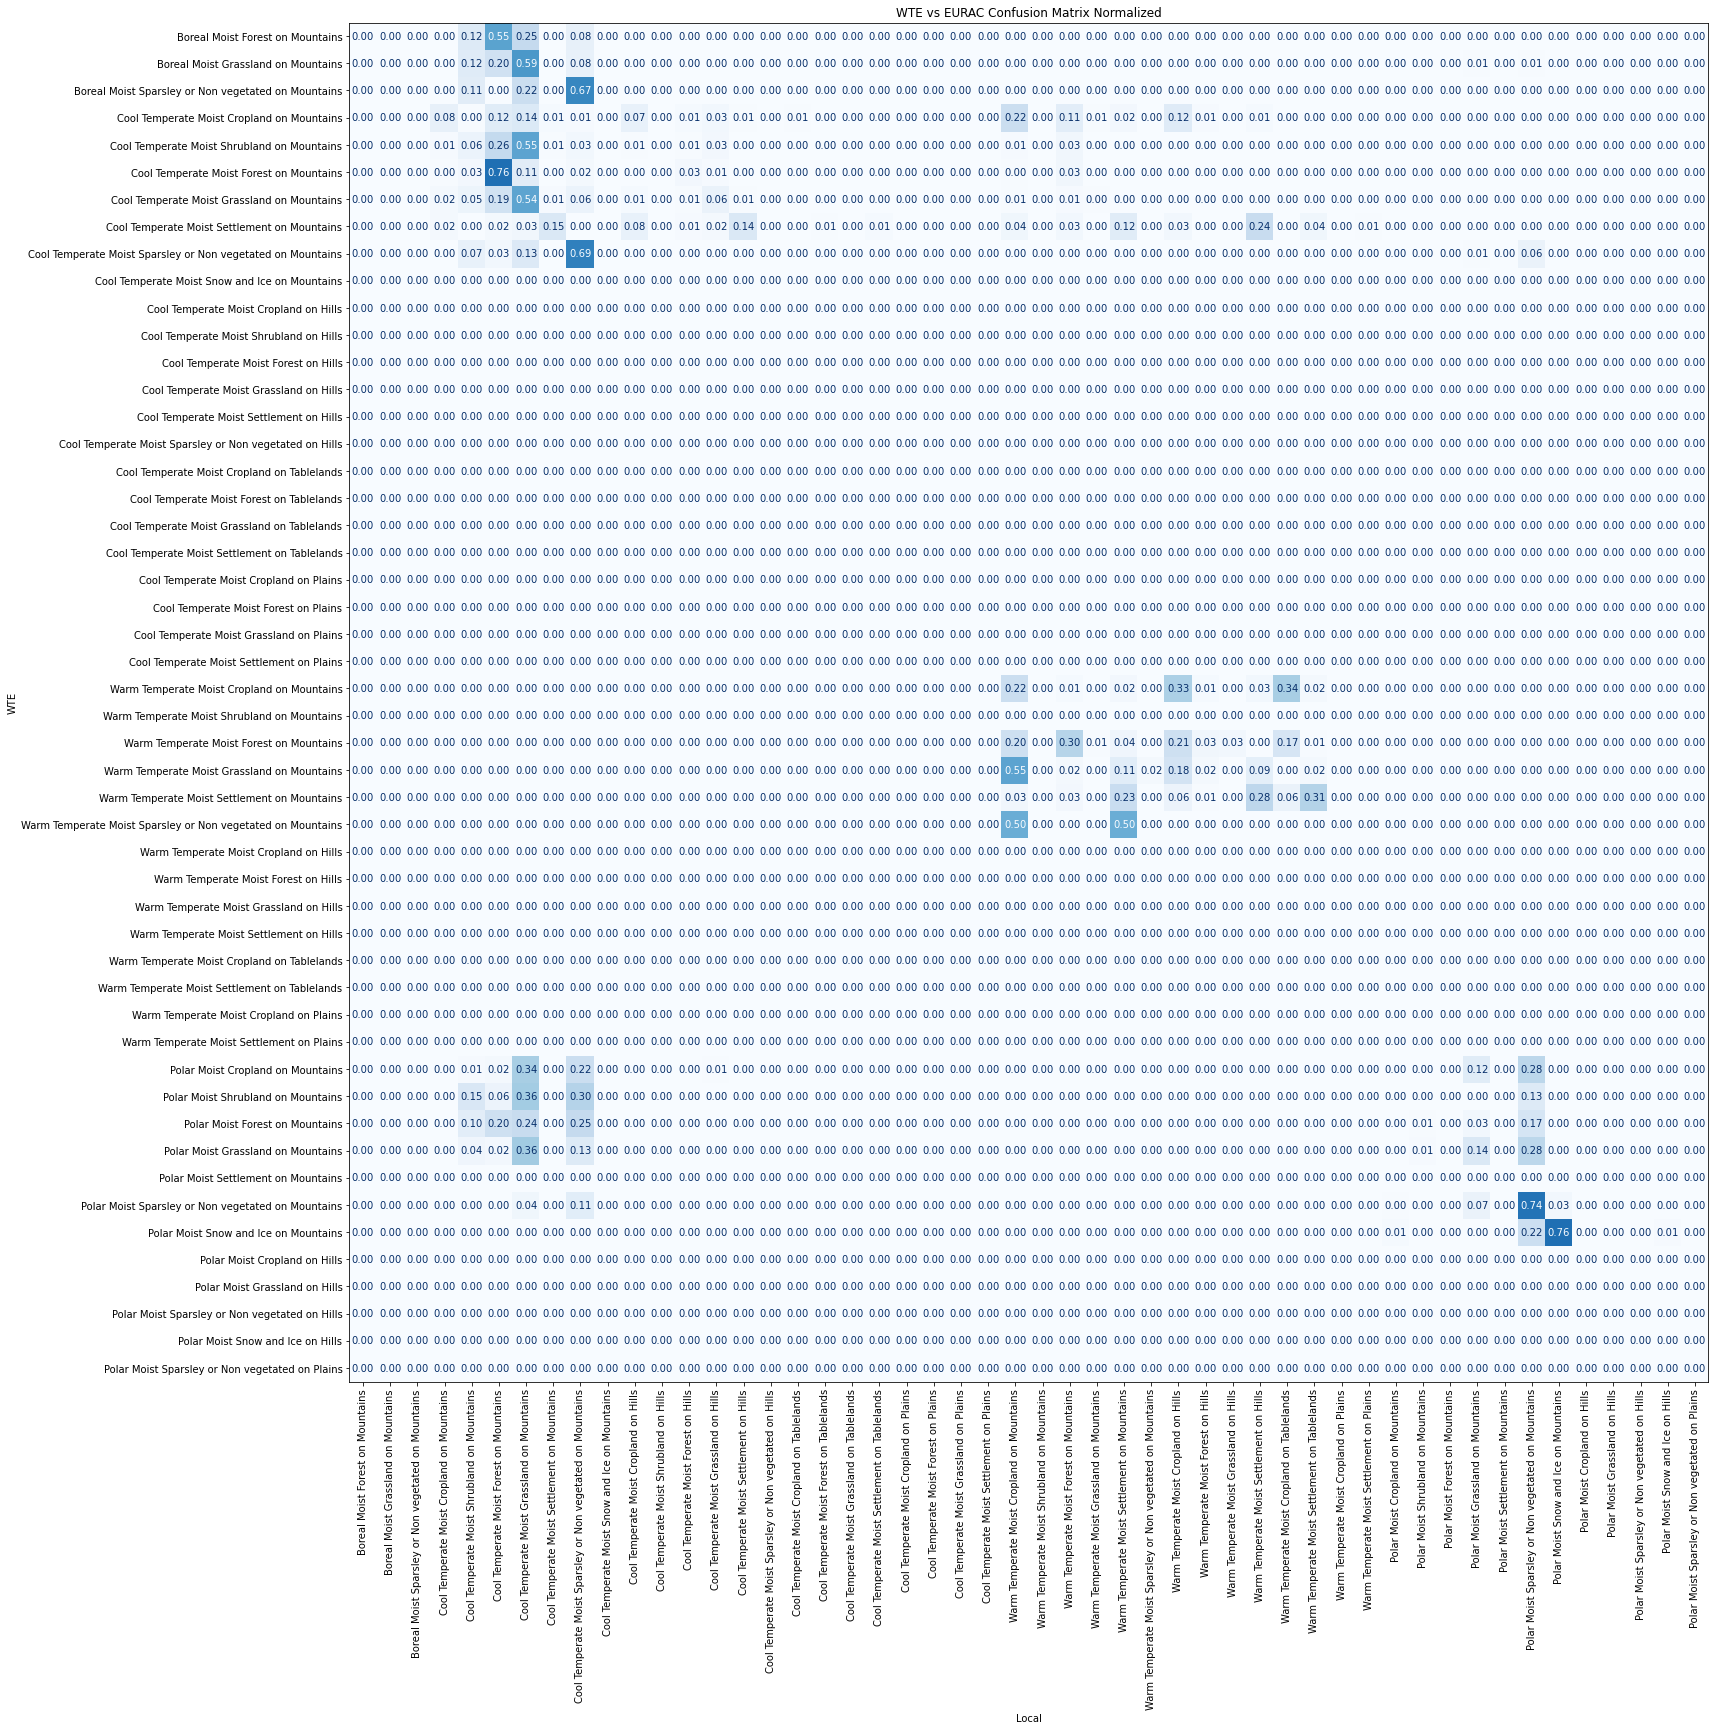

In [17]:
cm_wte_eurac = confusion_matrix(ecosystem_map_wte.flatten(), ecosystem_map_eurac.flatten(), labels=list(wte_eurac_classes))
cm_wte_eurac = cm_wte_eurac[1:,1:]
fig, ax = plt.subplots(1,1,figsize=(25,25))
ax.set_title("WTE vs EURAC Confusion Matrix Normalized")
plot_confusion_matrix(ax,cm_wte_eurac,wte_eurac_labels[1:],true="WTE",predicted="Local")

In [46]:
pixel_size_km2 = 0.25*0.25 #We are working with a grid of 250m x 250m
diagonal = 0
wrong = 0
for i in range(cm_wte_eurac.shape[0]):
    for j in range(cm_wte_eurac.shape[1]):
        if i==j:
            diagonal += cm_wte_eurac[i,j]
        else:
            wrong += cm_wte_eurac[i,j]
data = {'Disagreement [km^2]':  [wrong*pixel_size_km2*pixel_size_km2],
        'Disagreement [%]': [wrong/(diagonal+wrong)*100],
        }
df = pd.DataFrame(data, columns = ['Disagreement [km^2]','Disagreement [%]'],
                        index=['WTE vs Local'])

df

,Disagreement [km^2],Disagreement [%]
WTE vs Local,184.085938,40.169112


## WTE Ecosystem map from best combination of global layers
Temperature: Worldclim, Moisture: Chelsa, Landform: Merit, Land Cover: Globeland ECOSYSTEM MAP

In [19]:
TEMPERATURE_LAYER = "./worldclim_to_wte_temp_UTM_ST.nc"
MOISTURE_LAYER    = "./chelsa_to_wte_moist_UTM_ST.nc"
LANDFORM_LAYER    = "./merit_to_wte_lf_UTM_ST.nc"
LANDCOVER_LAYER   = "./globeland_lc_UTM_ST.nc"

In [20]:
temp = xr.open_dataarray(TEMPERATURE_LAYER)
moist = xr.open_dataarray(MOISTURE_LAYER)
landform = xr.open_dataarray(LANDFORM_LAYER)
landcover = xr.open_dataarray(LANDCOVER_LAYER)
landcover_array  = np.copy(landcover.values)
landform_array  = np.copy(landform.values)
moisture_array  = np.copy(moist.values)
temperature_array  = np.copy(temp.values)

In [21]:
ecosystem_R  = np.ones(landcover_array.shape)*255
ecosystem_G  = np.ones(landcover_array.shape)*255
ecosystem_B  = np.ones(landcover_array.shape)*255

number_of_valid_pixels = np.count_nonzero(landcover_array)

ecosystem_map_global_1  = np.zeros(landcover_array.shape)

global_1_labels = {}

tot_class_numb = 0

for lc in range(1,9): # landcover
    lc_mask = landcover_array==lc
    color0 = wte_table.loc[wte_table['LC_Class']==lc]
    lc_class_value = lc
    for lf in range(1,6):
        lf_mask = landform_array==lf
        color1 = color0.loc[wte_table['LF_Class']==lf]
        lf_class_value = lf*10
        for mois in range(1,4):
            moist_mask = moisture_array==mois
            color2 = color1.loc[wte_table['MoistClass']==mois]
            moist_class_value = mois*100
            for t in range(0,6):
                temperature_mask = temperature_array==t
                if t==0:
                    color3 = color2.loc[wte_table['TempClass']==6]
                    temp_class_value = 6*1000
                else:
                    color3 = color2.loc[wte_table['TempClass']==t]
                    temp_class_value = t*1000
                try:
                    color3['WTE_HEX'].values[0]
                    rgb_color = hex_to_rgb(color3['WTE_HEX'].values[0])
                    ecosystem_label = color3['WEcosystm'].values[0]
                    ecosystem_mask = lc_mask*lf_mask*moist_mask*temperature_mask
                    if (np.sum(ecosystem_mask)>0):
                        tot_class_numb +=1
#                         if ((np.sum(ecosystem_mask) / number_of_valid_pixels)>0.01):
                        ecosystem_R[ecosystem_mask] = rgb_color[0]
                        ecosystem_G[ecosystem_mask] = rgb_color[1]
                        ecosystem_B[ecosystem_mask] = rgb_color[2]
                        ecosystem_class = temp_class_value + moist_class_value + lf_class_value + lc_class_value
                        ecosystem_map_global_1[ecosystem_mask] = ecosystem_class
                        global_1_labels[str(int(ecosystem_class))] = ecosystem_label
                except:
                    continue

global_ecosystem = np.stack([ecosystem_R,ecosystem_G,ecosystem_B],axis=2)

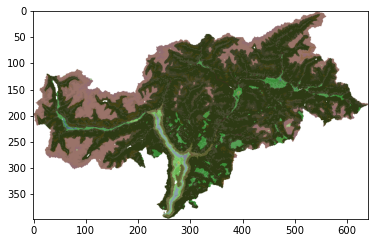

In [22]:
plt.imshow(global_ecosystem.astype(np.uint8),cmap='brg')

In [23]:
wte_global_1_classes = np.unique(np.concatenate([np.unique(ecosystem_map_wte),np.unique(ecosystem_map_global_1)])).astype(int)

In [24]:
wte_global_1_labels = []
for c in wte_global_1_classes:
    if c==0:
        wte_global_1_labels.append("NoClass")
        continue
    try:
        wte_global_1_labels.append(global_1_labels[str(c)])
    except:
        wte_global_1_labels.append(wte_labels[str(c)])

In [ ]:
cm_wte_global1 = confusion_matrix(ecosystem_map_wte.flatten(), ecosystem_map_global_1.flatten(), labels=list(wte_global_1_classes))
cm_wte_global1 = cm_wte_global1[1:,1:]
fig, ax = plt.subplots(1,1,figsize=(25,25))
ax.set_title("WTE vs Global 1 Confusion Matrix")
plot_confusion_matrix(ax,cm_wte_global1,wte_global_1_labels[1:],true="WTE",predicted="Global 1",normalize=None)

In [ ]:
cm_wte_global1 = confusion_matrix(ecosystem_map_wte.flatten(), ecosystem_map_global_1.flatten(), labels=list(wte_global_1_classes))
cm_wte_global1 = cm_wte_global1[1:,1:]
fig, ax = plt.subplots(1,1,figsize=(25,25))
ax.set_title("WTE vs Global 1 Confusion Matrix Normalized")
plot_confusion_matrix(ax,cm_wte_global1,wte_global_1_labels[1:],true="WTE",predicted="Global 1",normalize=True)

In [47]:
pixel_size_km2 = 0.25*0.25 #We are working with a grid of 250m x 250m
diagonal = 0
wrong = 0
for i in range(cm_wte_global1.shape[0]):
    for j in range(cm_wte_global1.shape[1]):
        if i==j:
            diagonal += cm_wte_global1[i,j]
        else:
            wrong += cm_wte_global1[i,j]
data = {'Disagreement [km^2]':  [wrong*pixel_size_km2*pixel_size_km2],
        'Disagreement [%]': [wrong/(diagonal+wrong)*100],
        }
df = pd.DataFrame(data, columns = ['Disagreement [km^2]','Disagreement [%]'],
                        index=['WTE vs Global 1'])

df

,Disagreement [km^2],Disagreement [%]
WTE vs Global 1,207.644531,45.150851


## WTE Ecosystem map from worst combination of global layers
Temperature: Chelsa, Moisture: CGIAR, Landform: SRTM, Land Cover: Copernicus ECOSYSTEM MAP

In [28]:
TEMPERATURE_LAYER = "./chelsa_to_wte_temp_UTM_ST.nc"
MOISTURE_LAYER    = "./cgiar_to_wte_moist_UTM_ST.nc"
LANDFORM_LAYER    = "./srtm_to_wte_lf_UTM_ST.nc"
LANDCOVER_LAYER   = "./cglc_lc_UTM_ST.nc"

In [29]:
temp = xr.open_dataarray(TEMPERATURE_LAYER)
moist = xr.open_dataarray(MOISTURE_LAYER)
landform = xr.open_dataarray(LANDFORM_LAYER)
landcover = xr.open_dataarray(LANDCOVER_LAYER)
landcover_array  = np.copy(landcover.values)
landform_array  = np.copy(landform.values)
moisture_array  = np.copy(moist.values)
temperature_array  = np.copy(temp.values)

In [30]:
ecosystem_R  = np.ones(landcover_array.shape)*255
ecosystem_G  = np.ones(landcover_array.shape)*255
ecosystem_B  = np.ones(landcover_array.shape)*255

ecosystem_map_global_2  = np.zeros(landcover_array.shape)

number_of_valid_pixels = np.count_nonzero(landcover_array)

global_2_labels = {}

tot_class_numb = 0

for lc in range(1,9): # landcover
    lc_mask = landcover_array==lc
    color0 = wte_table.loc[wte_table['LC_Class']==lc]
    lc_class_value = lc
    for lf in range(1,6):
        lf_mask = landform_array==lf
        color1 = color0.loc[wte_table['LF_Class']==lf]
        lf_class_value = lf*10
        for mois in range(1,4):
            moist_mask = moisture_array==mois
            color2 = color1.loc[wte_table['MoistClass']==mois]
            moist_class_value = mois*100
            for t in range(0,6):
                temperature_mask = temperature_array==t
                if t==0:
                    color3 = color2.loc[wte_table['TempClass']==6]
                    temp_class_value = 6*1000
                else:
                    color3 = color2.loc[wte_table['TempClass']==t]
                    temp_class_value = t*1000
                try:
                    color3['WTE_HEX'].values[0]
                    rgb_color = hex_to_rgb(color3['WTE_HEX'].values[0])
                    ecosystem_label = color3['WEcosystm'].values[0]
                    ecosystem_mask = lc_mask*lf_mask*moist_mask*temperature_mask
                    if (np.sum(ecosystem_mask)>0):
                        tot_class_numb +=1
#                         if ((np.sum(ecosystem_mask) / number_of_valid_pixels)>0.01):
                        ecosystem_R[ecosystem_mask] = rgb_color[0]
                        ecosystem_G[ecosystem_mask] = rgb_color[1]
                        ecosystem_B[ecosystem_mask] = rgb_color[2]
                        ecosystem_class = temp_class_value + moist_class_value + lf_class_value + lc_class_value
                        ecosystem_map_global_2[ecosystem_mask] = ecosystem_class
                        global_2_labels[str(int(ecosystem_class))] = ecosystem_label
                except:
                    continue

global_ecosystem_2 = np.stack([ecosystem_R,ecosystem_G,ecosystem_B],axis=2)

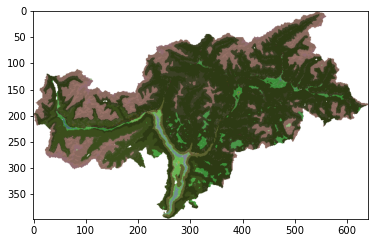

In [31]:
plt.imshow(global_ecosystem_2.astype(np.uint8),cmap='brg')

In [32]:
wte_global_2_classes = np.unique(np.concatenate([np.unique(ecosystem_map_wte),np.unique(ecosystem_map_global_2)])).astype(int)

In [33]:
wte_global_2_labels = []
for c in wte_global_2_classes:
    if c==0:
        wte_global_2_labels.append("NoClass")
        continue
    try:
        wte_global_2_labels.append(global_2_labels[str(c)])
    except:
        wte_global_2_labels.append(wte_labels[str(c)])

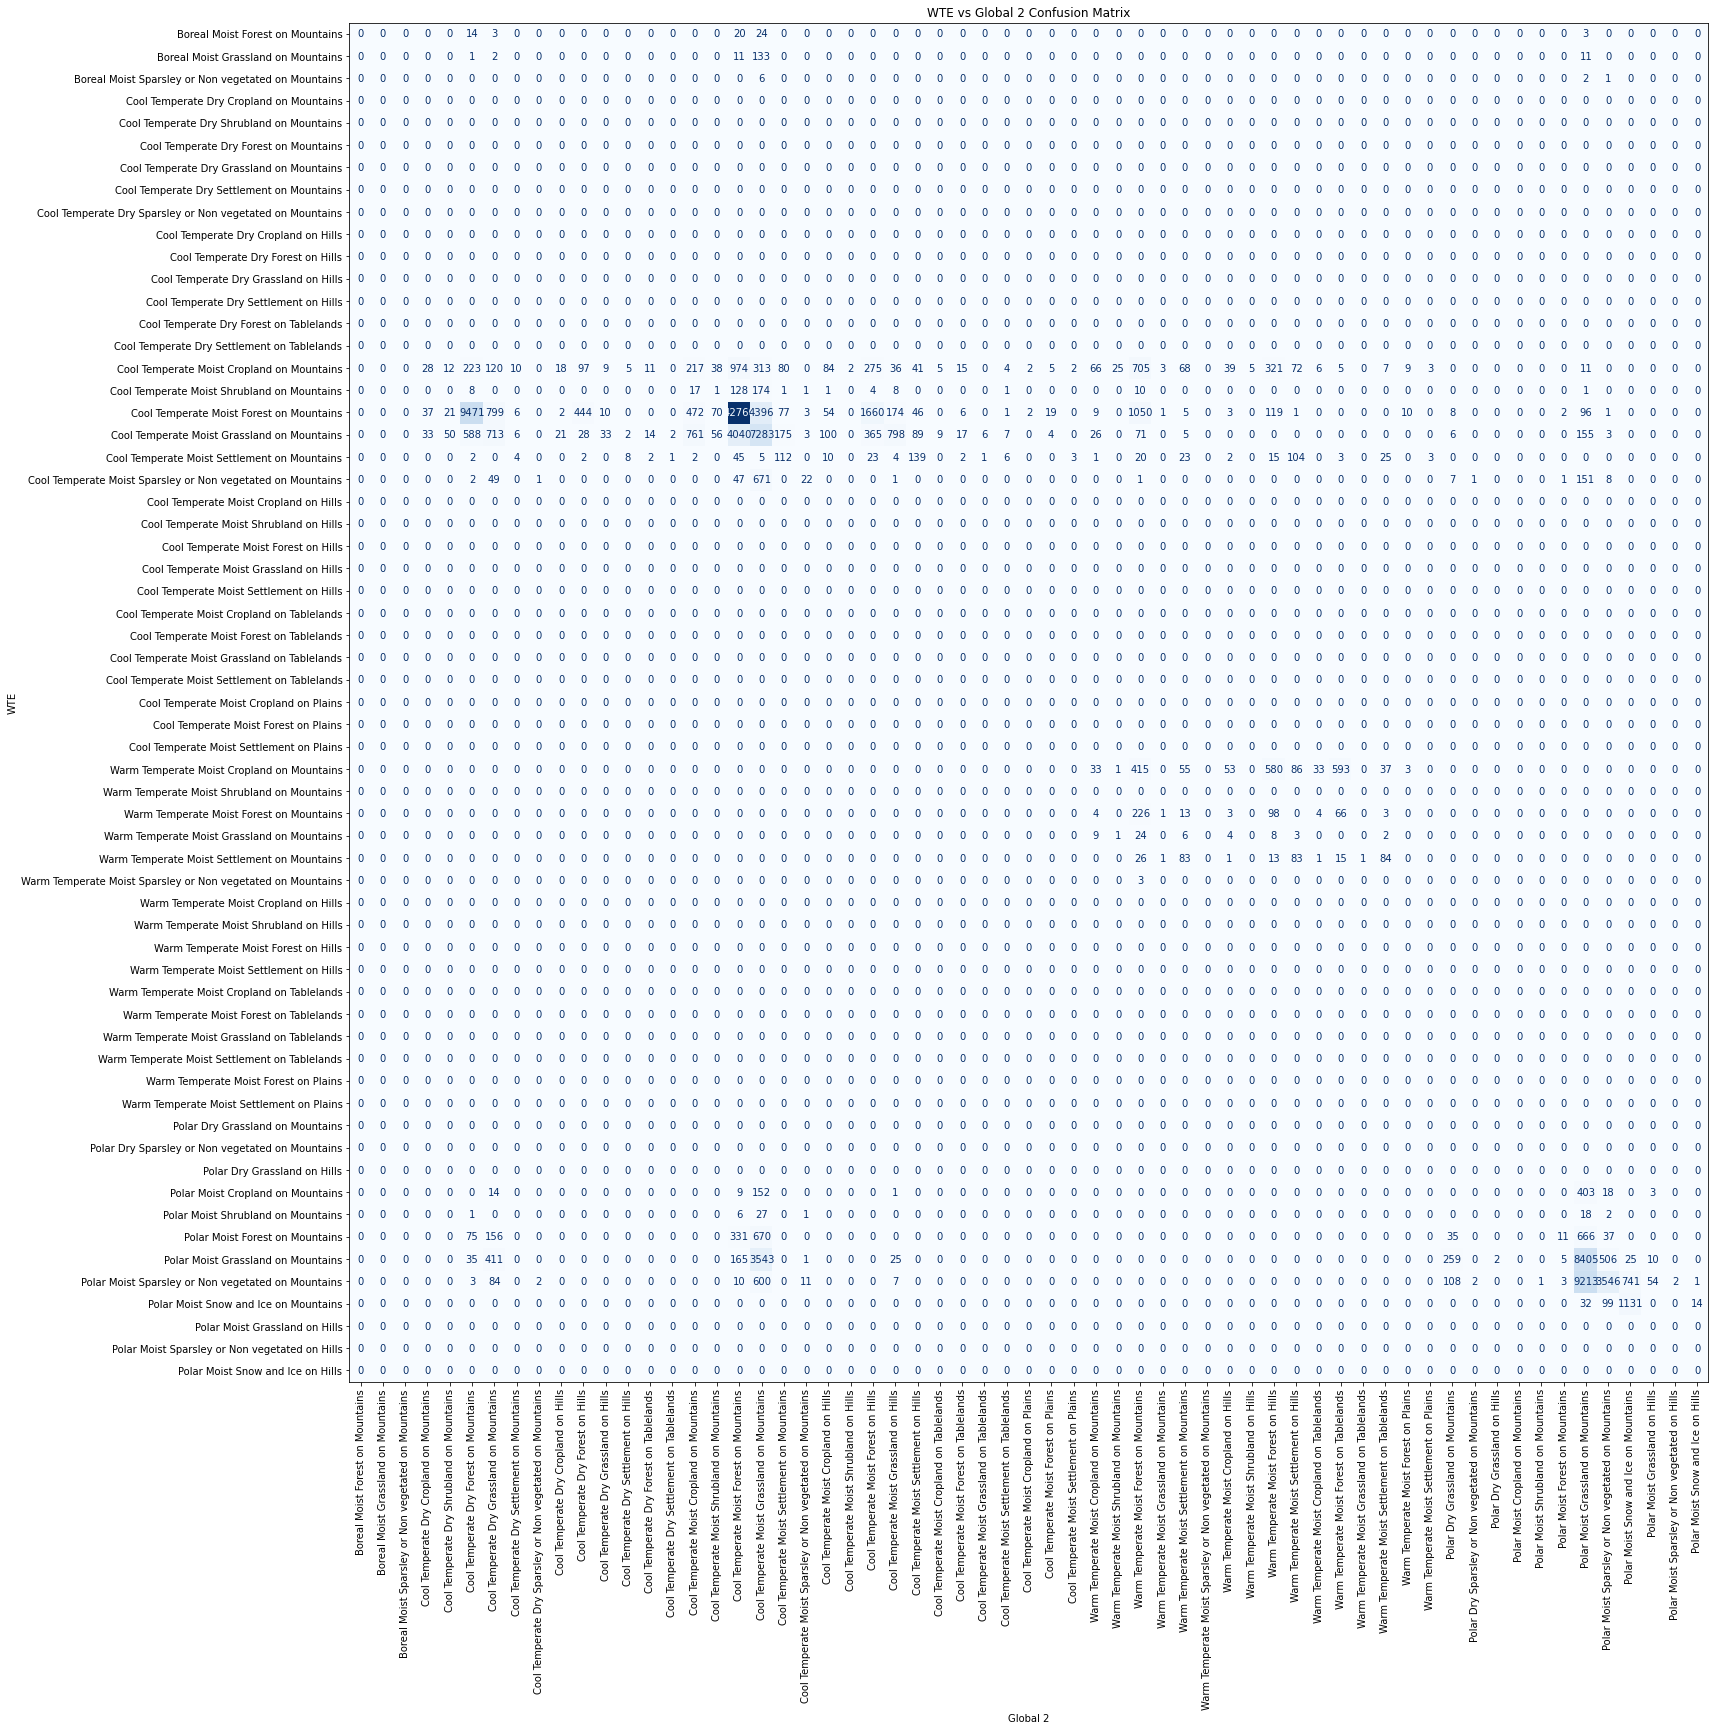

In [37]:
cm_wte_global2 = confusion_matrix(ecosystem_map_wte.flatten(), ecosystem_map_global_2.flatten(), labels=list(wte_global_2_classes))
cm_wte_global2 = cm_wte_global2[1:,1:]
fig, ax = plt.subplots(1,1,figsize=(25,25))
ax.set_title("WTE vs Global 2 Confusion Matrix")
plot_confusion_matrix(ax,cm_wte_global2,wte_global_2_labels[1:],true="WTE",predicted="Global 2",normalize=None)

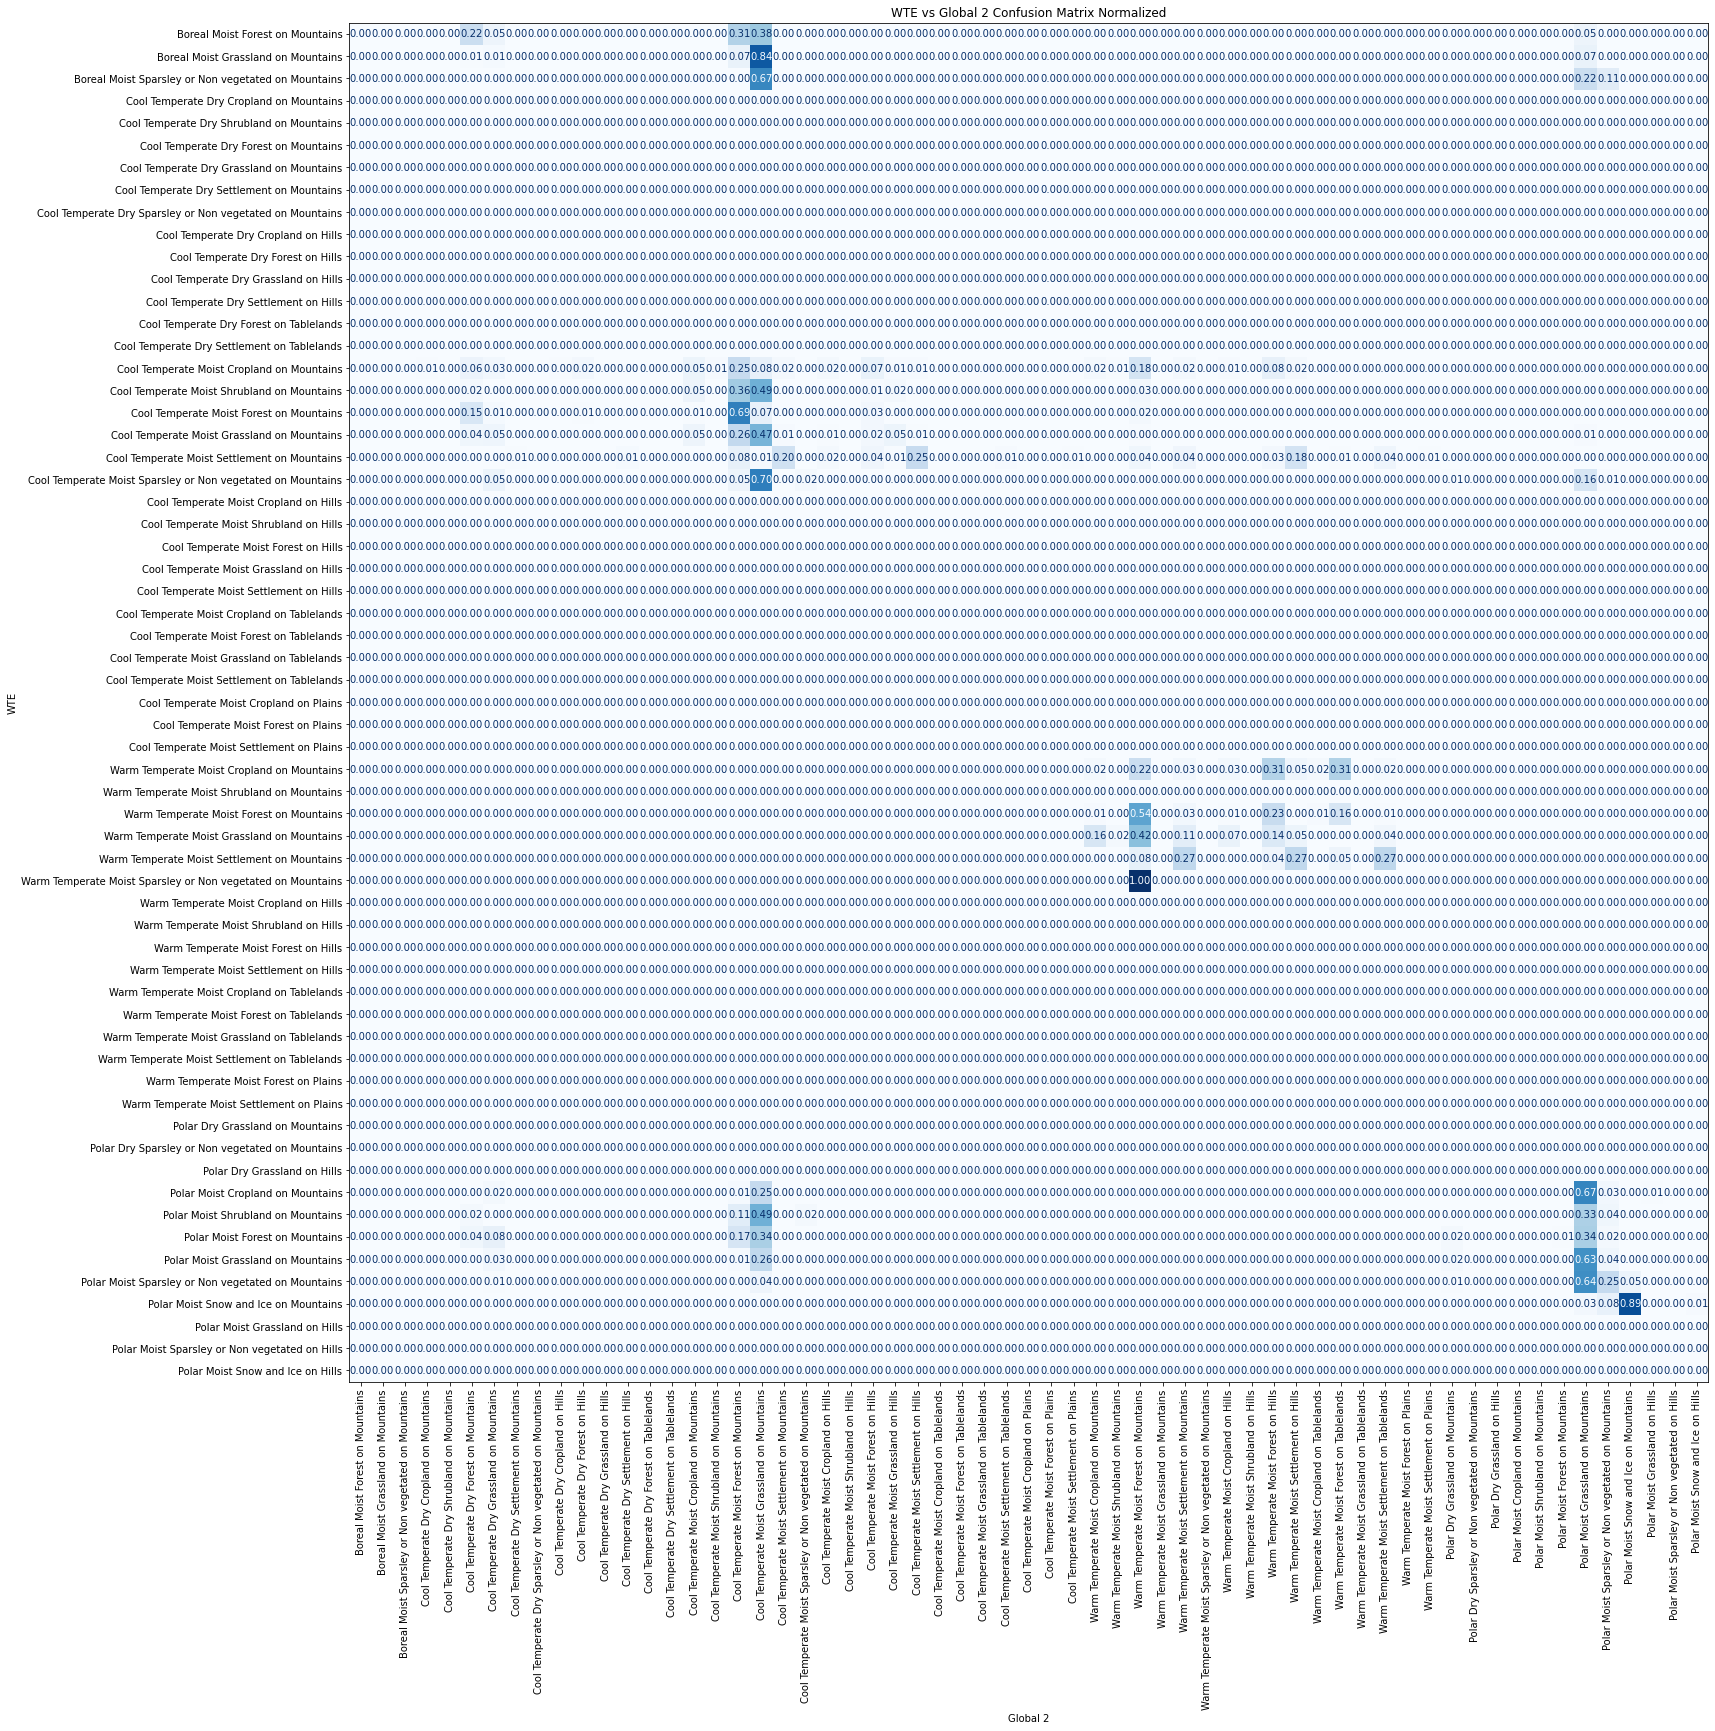

In [38]:
cm_wte_global2 = confusion_matrix(ecosystem_map_wte.flatten(), ecosystem_map_global_2.flatten(), labels=list(wte_global_2_classes))
cm_wte_global2 = cm_wte_global2[1:,1:]
fig, ax = plt.subplots(1,1,figsize=(25,25))
ax.set_title("WTE vs Global 2 Confusion Matrix Normalized")
plot_confusion_matrix(ax,cm_wte_global2,wte_global_2_labels[1:],true="WTE",predicted="Global 2",normalize=True)

In [40]:
pixel_size_km2 = 0.25*0.25 #We are working with a grid of 250m x 250m
diagonal = 0
wrong = 0
for i in range(cm_wte_global2.shape[0]):
    for j in range(cm_wte_global2.shape[1]):
        if i==j:
            diagonal += cm_wte_global2[i,j]
        else:
            wrong += cm_wte_global2[i,j]
data = {'Disagreement [km^2]':  [wrong*pixel_size_km2*pixel_size_km2],
        'Disagreement [%]': [wrong/(diagonal+wrong)*100],
        }
df = pd.DataFrame(data, columns = ['Disagreement [km^2]','Disagreement [%]'],
                        index=['WTE vs Global 2'])

df

,Disagreement [km^2],Disagreement [%]
WTE vs Global 2,210.652344,45.795154


In [48]:
na_mask = np.where(wte_ecosystem[:,:,0]==255)
wte_ecosystem_masked = wte_ecosystem.copy()
wte_ecosystem_masked[wte_ecosystem_masked==255] = 0
#WTE vs EURAC:
diff_wte_eurac = (np.mean(abs(wte_ecosystem - eurac_ecosystem),axis=2)>0).astype(float)
#WTE vs GLOBAL 1:
diff_wte_global = (np.mean(abs(wte_ecosystem - global_ecosystem),axis=2)>0).astype(float)
#WTE vs GLOBAL 2:
diff_wte_global_2 = (np.mean(abs(wte_ecosystem - global_ecosystem_2),axis=2)>0).astype(float)

Define colors and labels for plotting:

In [49]:
colors_diff = ["#E0E0E0","#FFAA00"]
labels_diff = ["same","different"]
legend_diff = []
for i,x in enumerate(labels_diff):
    legend_diff.append(mpatches.Patch(color=colors_diff[i],label=x))

Create cmap for difference layer

In [50]:
diff_cmap = ListedColormap(["#E0E0E0","#FFAA00"])

Plot the results

[]

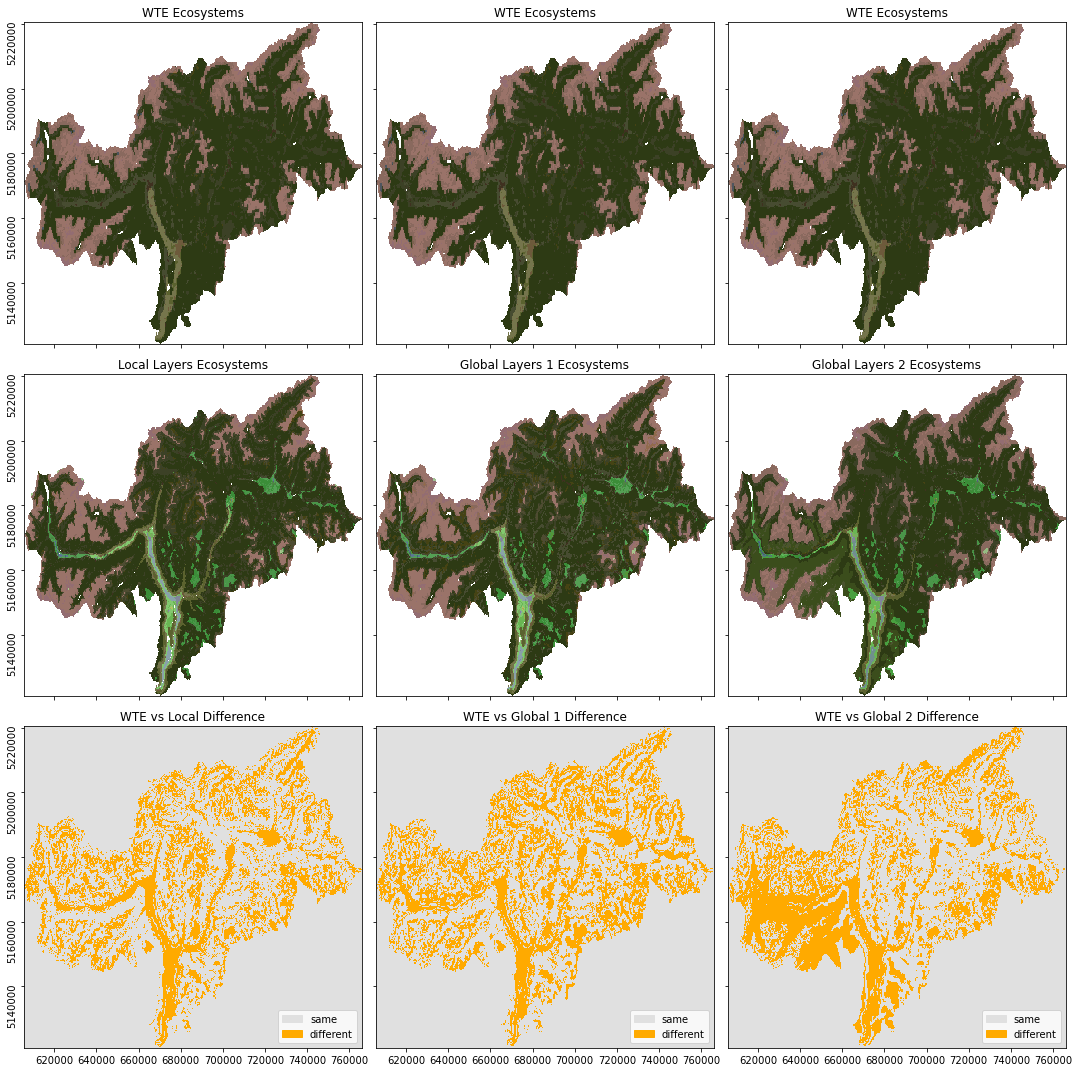

In [51]:
wte_ecosystem = wte_ecosystem.astype(np.int16)
eurac_ecosystem = eurac_ecosystem.astype(np.int16)
global_ecosystem = global_ecosystem.astype(np.int16)
global_ecosystem_2 = global_ecosystem_2.astype(np.int16)
axis_xmin = landcover.x.min().values
axis_ymin = landcover.y.min().values
axis_xmax = landcover.x.max().values
axis_ymax = landcover.y.max().values
na_mask = np.where(wte_ecosystem[:,:,0]==255)

tmp_r = xr.ones_like(landcover)#.copy(deep=True)
tmp_g = xr.ones_like(landcover)#.copy(deep=True)
tmp_b = xr.ones_like(landcover)#.copy(deep=True)

wte_tmp_r = (tmp_r * wte_ecosystem[:,:,0]).astype(np.uint8)
wte_tmp_g = (tmp_g * wte_ecosystem[:,:,1]).astype(np.uint8)
wte_tmp_b = (tmp_b * wte_ecosystem[:,:,2]).astype(np.uint8)
wte_tmp_r['color'] = 'r'
wte_tmp_g['color'] = 'g'
wte_tmp_b['color'] = 'b'
tmp_wte = xr.concat([wte_tmp_r,wte_tmp_g,wte_tmp_b],dim='color')

fig, ax = plt.subplots(3,3,figsize=(15,15))
tmp_wte.plot.imshow(ax=ax[0,0],cmap='brg',extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[0,0].set_title("WTE Ecosystems")
tmp_wte.plot.imshow(ax=ax[0,1],cmap='brg',extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[0,1].set_title("WTE Ecosystems")
tmp_wte.plot.imshow(ax=ax[0,2],cmap='brg',extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[0,2].set_title("WTE Ecosystems")

tmp_r = xr.ones_like(landcover)#.copy(deep=True)
tmp_g = xr.ones_like(landcover)#.copy(deep=True)
tmp_b = xr.ones_like(landcover)#.copy(deep=True)

tmp_r = (tmp_r * eurac_ecosystem[:,:,0]).astype(np.uint8)
tmp_g = (tmp_g * eurac_ecosystem[:,:,1]).astype(np.uint8)
tmp_b = (tmp_b * eurac_ecosystem[:,:,2]).astype(np.uint8)
tmp_r['color'] = 'r'
tmp_g['color'] = 'g'
tmp_b['color'] = 'b'
tmp = xr.concat([tmp_r,tmp_g,tmp_b],dim='color')

tmp.plot.imshow(ax=ax[1,0],cmap='brg',extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[1,0].set_title("Local Layers Ecosystems")

tmp_r = xr.ones_like(landcover)#.copy(deep=True)
tmp_g = xr.ones_like(landcover)#.copy(deep=True)
tmp_b = xr.ones_like(landcover)#.copy(deep=True)

tmp_r = (tmp_r * global_ecosystem[:,:,0]).astype(np.uint8)
tmp_g = (tmp_g * global_ecosystem[:,:,1]).astype(np.uint8)
tmp_b = (tmp_b * global_ecosystem[:,:,2]).astype(np.uint8)
tmp_r['color'] = 'r'
tmp_g['color'] = 'g'
tmp_b['color'] = 'b'
tmp = xr.concat([tmp_r,tmp_g,tmp_b],dim='color')

tmp.plot.imshow(ax=ax[1,1],cmap='brg',extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[1,1].set_title("Global Layers 1 Ecosystems")

tmp_r = xr.ones_like(landcover)#.copy(deep=True)
tmp_g = xr.ones_like(landcover)#.copy(deep=True)
tmp_b = xr.ones_like(landcover)#.copy(deep=True)

tmp_r = (tmp_r * global_ecosystem_2[:,:,0]).astype(np.uint8)
tmp_g = (tmp_g * global_ecosystem_2[:,:,1]).astype(np.uint8)
tmp_b = (tmp_b * global_ecosystem_2[:,:,2]).astype(np.uint8)
tmp_r['color'] = 'r'
tmp_g['color'] = 'g'
tmp_b['color'] = 'b'
tmp = xr.concat([tmp_r,tmp_g,tmp_b],dim='color')

tmp.plot.imshow(ax=ax[1,2],cmap='brg',extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax])
ax[1,2].set_title("Global Layers 2 Ecosystems")

tmp = xr.ones_like(landcover)#.copy(deep=True)
tmp = tmp * diff_wte_eurac
tmp = tmp.where(tmp<255)

tmp.plot.imshow(ax=ax[2,0],cmap=diff_cmap,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax],add_colorbar=False)
ax[2,0].set_title("WTE vs Local Difference")
ax[2,0].legend(handles=legend_diff,loc='lower right')

tmp = xr.ones_like(landcover)#.copy(deep=True)
tmp = tmp * diff_wte_global
tmp = tmp.where(tmp<255)

tmp.plot.imshow(ax=ax[2,1],cmap=diff_cmap,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax],add_colorbar=False)
ax[2,1].set_title("WTE vs Global 1 Difference")
ax[2,1].legend(handles=legend_diff,loc='lower right')

tmp = xr.ones_like(landcover)#.copy(deep=True)
tmp = tmp * diff_wte_global_2
tmp = tmp.where(tmp<255)

tmp.plot.imshow(ax=ax[2,2],cmap=diff_cmap,extent=[axis_xmin,axis_xmax,axis_ymin,axis_ymax],add_colorbar=False)
ax[2,2].set_title("WTE vs Global 2 Difference")
ax[2,2].legend(handles=legend_diff,loc='lower right')
    
# rotate y-tick labels
for i in ax[:3]:
    for k in i[:]:
        for label in k.get_yticklabels():
            label.set_rotation(90)
    
# remove all axis labels
for i in ax[:3]:
    for k in i[:]:
        k.set_xlabel("")
        k.set_ylabel("")  
        k.ticklabel_format(style='plain')
for i in ax[:2]:
    for k in i[:]:
        for i, tick in enumerate(k.xaxis.get_ticklabels()):
            tick.set_visible(False)
for i in ax[:]:
    for k in i[1:]:
        for i, tick in enumerate(k.yaxis.get_ticklabels()):
            tick.set_visible(False)
            
plt.tight_layout()
plt.plot()